# Traffic Signal Detection

In [1]:
# Imports required things
import os
import cv2
import numpy as np
import pandas as pd
import imutils
from imutils import paths
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.layers import Flatten, Dropout, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [2]:
# unzip dataset
!unzip -q ./dataset.zip -d ./dataset

In [3]:
# Making path for images and annotations
basePath = os.getcwd()
currentPath = basePath + '/dataset'
images = currentPath + '/images'
annotations = currentPath + '/annotations.csv'
print(currentPath)
print(images)
print(annotations)


/content/dataset
/content/dataset/images
/content/dataset/annotations.csv


In [4]:
# Perform checking on annotations
df = pd.read_csv(annotations)
df.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,No_Uturn,28,9,81,99,1.png,123,121
1,No_Uturn,16,9,68,67,10.png,96,88
2,Go_Left,19,7,107,104,100.png,143,127
3,Go_Left,28,23,100,102,101.png,154,153
4,Go_Left,29,15,129,126,102.png,171,154


In [5]:
# Performing OneHotEncoding
classNameEncoding = {}
label_to_class_names = {
    0: 'Uturn',
    1: 'No_Uturn',
    2: 'Zebra_Crossing',
    3: 'No_Stopping',
    4: 'No_Horn',
    5: 'No_Entry',
    6: 'No_Car',
    7: 'Go_Left',
    8: 'Fences',
    9: 'Danger_Ahead'
}
for i in label_to_class_names:
  lst = [0] * len(label_to_class_names)
  lst[i] = 1
  classNameEncoding[label_to_class_names[i]] = lst
print(classNameEncoding)

{'Uturn': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'No_Uturn': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'Zebra_Crossing': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 'No_Stopping': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 'No_Horn': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'No_Entry': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'No_Car': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 'Go_Left': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'Fences': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'Danger_Ahead': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}


In [6]:
# Getting all images(resizing), bounding points and labels.
allImagesData=[]
boxBoderPoints=[]
labels=[]

for index, item in df.iterrows():
  imageData = {
      'label' : item.iloc[0],
      'bboxX' : item.iloc[1],
      'bboxY' : item.iloc[2],
      'width' : item.iloc[3],
      'height': item.iloc[4],
      'imageName': item.iloc[5]
      }
  # Image Reading
  imagepath=os.path.join(images, imageData['imageName'])
  image=cv2.imread(imagepath)
  (imgHeight,imgWidth)=image.shape[:2]
  # Image Shape data
  imageShape = {
      'xPoint': float(imageData['bboxX']) / imgWidth,
      'yPoint': float(imageData['bboxY']) / imgHeight,
      'width': float(imageData['width']) / imgHeight,
      'height': float(imageData['height']) / imgWidth
  }
  # Image Loading
  image=load_img(imagepath, target_size=(224,224))
  # Data collection
  allImagesData.append(img_to_array(image))
  boxBoderPoints.append(tuple(imageShape.values()))
  labels.append(classNameEncoding[imageData['label']])

In [7]:
# Data Normalizing
labels = np.array(labels)
boxBoderPoints=np.array(boxBoderPoints, dtype='float32')
allImagesData=np.array(allImagesData, dtype='float32') / 255.0

# Printing Shapes
allImagesData.shape, boxBoderPoints.shape, labels.shape

((280, 224, 224, 3), (280, 4), (280, 10))

In [8]:
# Splitting Data
split = train_test_split(allImagesData, labels, boxBoderPoints,test_size=0.20, random_state=42)
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:]
(trainImages, testImages) = split[:2]

# Printing Shapes
trainImages.shape, testImages.shape, trainLabels.shape, trainBBoxes.shape

((224, 224, 224, 3), (56, 224, 224, 3), (224, 10), (224, 4))

In [9]:
# Load the ResNet50 model
model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
model.trainable = False
# flatten the max-pooling output of ResNet50
flatten = model.output
flatten = Flatten()(flatten)
boxBounding = Dense(128, activation="relu")(flatten)
boxBounding = Dense(64, activation="relu")(boxBounding)
boxBounding = Dense(32, activation="relu")(boxBounding)
boxBounding = Dense(4, activation="sigmoid", name="box_bounding")(boxBounding)

labelsLayer = Dense(512, activation="relu")(flatten)
labelsLayer = Dropout(0.5)(labelsLayer)
labelsLayer = Dense(10, activation="softmax", name="labels_Layer")(labelsLayer)

model = Model(model.input, [labelsLayer, boxBounding])
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [10]:
model.compile(
    optimizer=Adam(0.00001, clipvalue=100), 
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[5, 0.25],metrics=['accuracy']
)
# train model for 50 epochs
history = model.fit(
    trainImages, 
    [trainLabels, trainBBoxes],
    validation_data = (testImages, [testLabels, testBBoxes]),
    batch_size = 16, 
    epochs = 50,
    verbose = 1
)

Epoch 1/50
14/14 [==============================] - 13s 207ms/step - loss: 15.5500 - labels_Layer_loss: 3.1087 - box_bounding_loss: 0.0257 - labels_Layer_accuracy: 0.0714 - box_bounding_accuracy: 0.2634 - val_loss: 11.4653 - val_labels_Layer_loss: 2.2924 - val_box_bounding_loss: 0.0123 - val_labels_Layer_accuracy: 0.1786 - val_box_bounding_accuracy: 0.1071
Epoch 2/50
14/14 [==============================] - 1s 96ms/step - loss: 13.3238 - labels_Layer_loss: 2.6643 - box_bounding_loss: 0.0091 - labels_Layer_accuracy: 0.1250 - box_bounding_accuracy: 0.3080 - val_loss: 10.4209 - val_labels_Layer_loss: 2.0838 - val_box_bounding_loss: 0.0077 - val_labels_Layer_accuracy: 0.3214 - val_box_bounding_accuracy: 0.7857
Epoch 3/50
14/14 [==============================] - 1s 84ms/step - loss: 11.6693 - labels_Layer_loss: 2.3335 - box_bounding_loss: 0.0065 - labels_Layer_accuracy: 0.1964 - box_bounding_accuracy: 0.7411 - val_loss: 10.0784 - val_labels_Layer_loss: 2.0154 - val_box_bounding_loss: 0.0060

In [11]:
# Saving model and weights in .h5 file.
modelSavePath = os.path.join(basePath, 'resnet50.h5')
model.save(modelSavePath)
model.load_weights(modelSavePath)

In [12]:
# Model evaluation
model.evaluate(testImages, [testLabels, testBBoxes], batch_size=8)

7/7 [==============================] - 0s 46ms/step - loss: 3.9102 - labels_Layer_loss: 0.7819 - box_bounding_loss: 0.0028 - labels_Layer_accuracy: 0.8571 - box_bounding_accuracy: 0.8929


[3.910210132598877,
 0.7818999290466309,
 0.0028436409775167704,
 0.8571428656578064,
 0.8928571343421936]

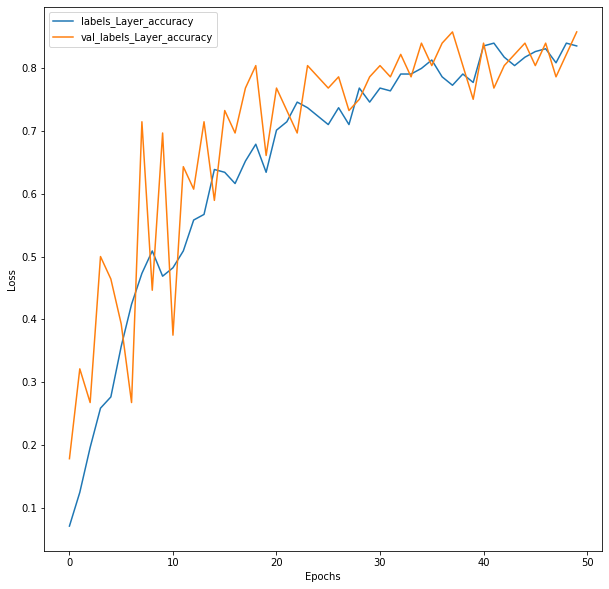

In [13]:
# Train and Validation accuracy graph
plt.figure(figsize=(10, 10))
plt.plot(history.history['labels_Layer_accuracy'], label='labels_Layer_accuracy')
plt.plot(history.history['val_labels_Layer_accuracy'], label='val_labels_Layer_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

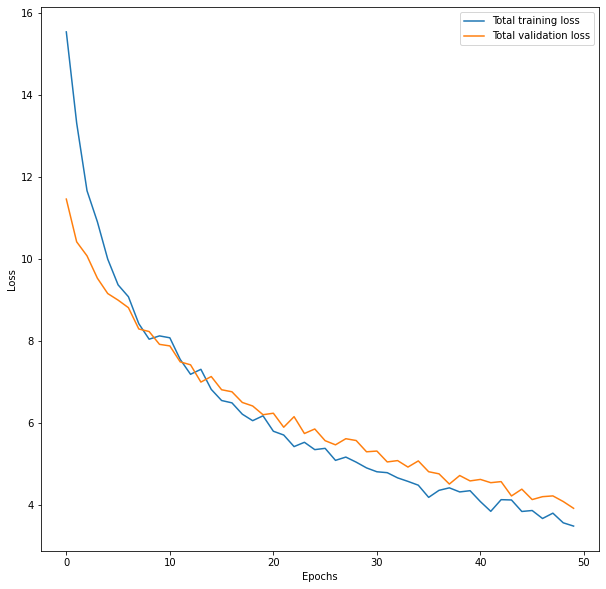

In [14]:
# Train and Validation loss graph
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='Total training loss')
plt.plot(history.history['val_loss'], label='Total validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step


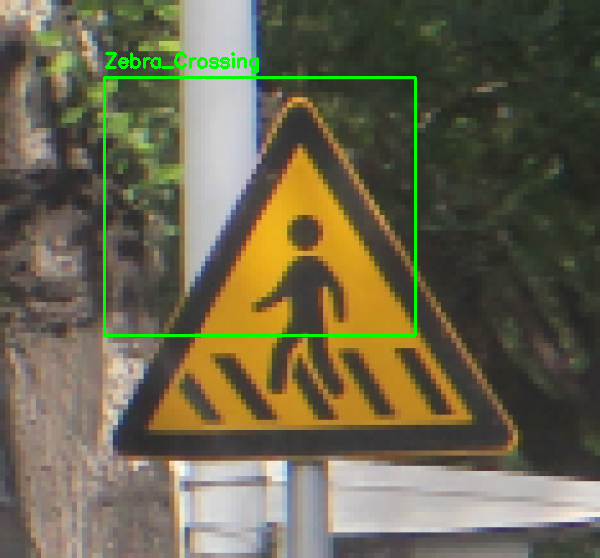

1/1 [==============================] - 0s 21ms/step


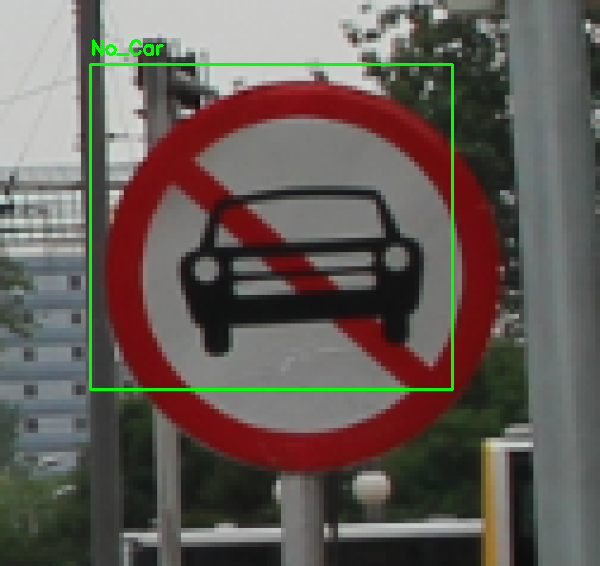

1/1 [==============================] - 0s 22ms/step


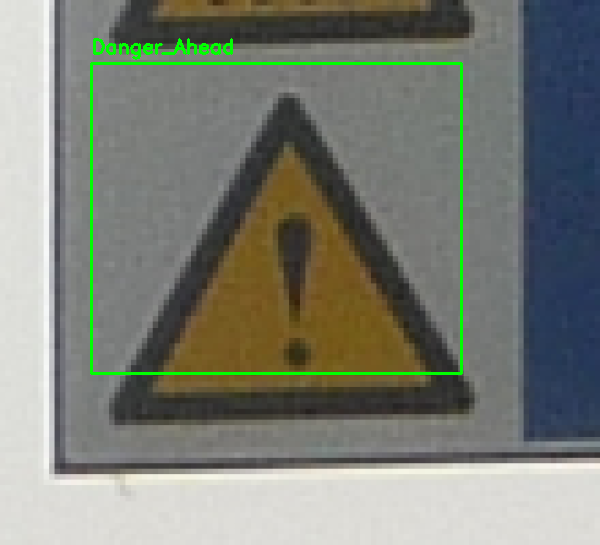

1/1 [==============================] - 0s 23ms/step


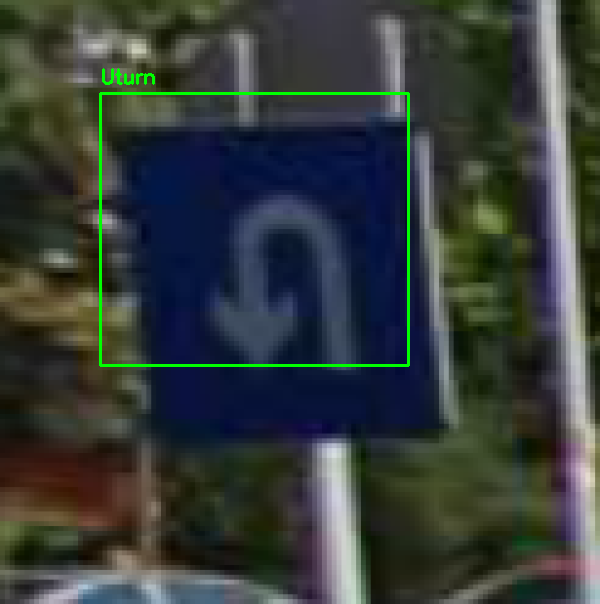

1/1 [==============================] - 0s 21ms/step


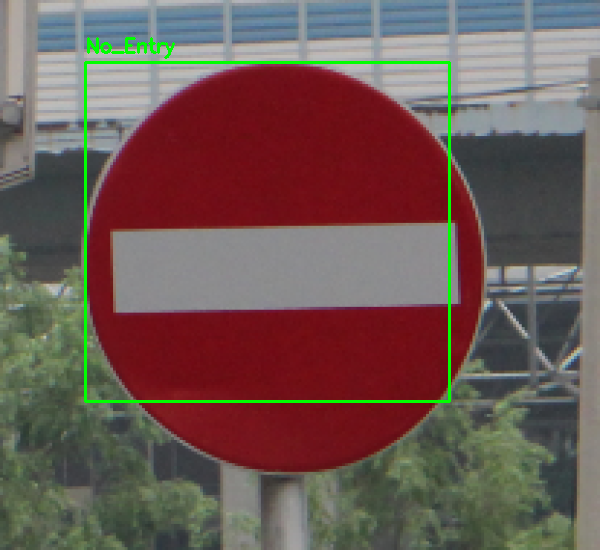

1/1 [==============================] - 0s 26ms/step


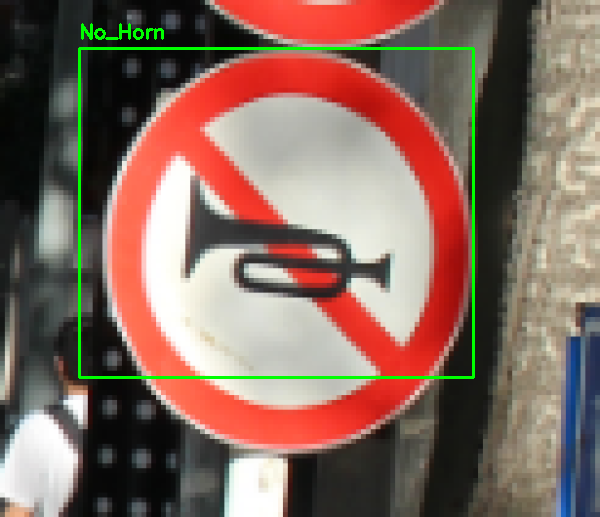

1/1 [==============================] - 0s 24ms/step


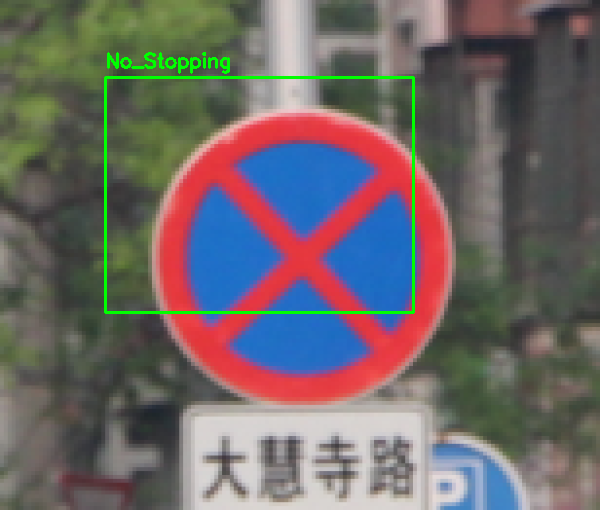

1/1 [==============================] - 0s 25ms/step


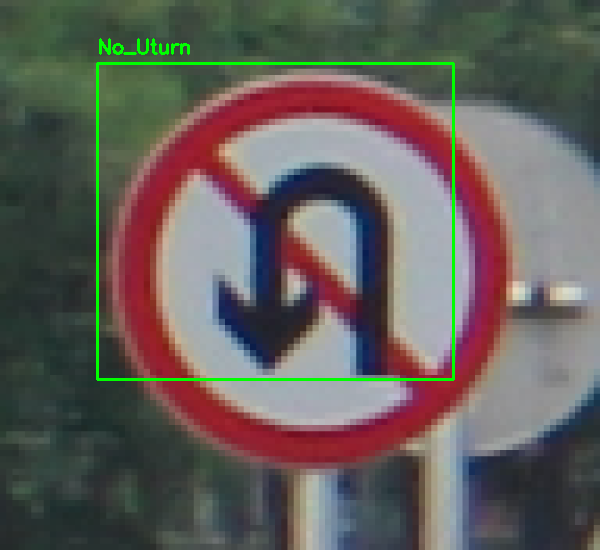

1/1 [==============================] - 0s 24ms/step


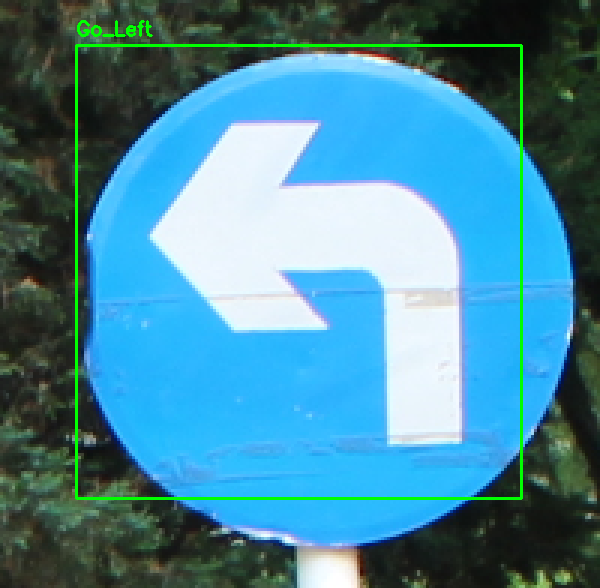

1/1 [==============================] - 0s 22ms/step


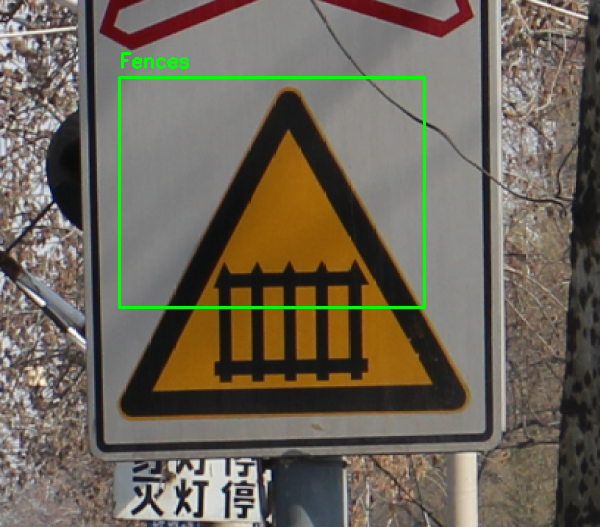

In [15]:
# Model testing with some sample images

testImagesPath = currentPath + '/test'
allPaths = os.listdir(testImagesPath)
for path in allPaths:
  imagePath=os.path.join(testImagesPath, path)
  image = load_img(imagePath, target_size=(224, 224))
  image = np.expand_dims((img_to_array(image) / 255.0), axis=0)

  # Prediction
  (labelPreds,boxPreds ) = model.predict(image)

  # Processing
  (xPoint, yPoint, width, height) = boxPreds[0]
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]
  xPoint = int(xPoint * w)
  yPoint = int(yPoint * h)
  width = int(width * w)
  height = int(height * h)
  label = label_to_class_names[np.argmax(labelPreds)]
  y = yPoint - 10 if yPoint - 10 > 10 else yPoint + 10
  cv2.putText(image, label, (xPoint, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
  cv2.rectangle(image, (xPoint, yPoint), (width, height), (0, 255, 0), 2)

  # Showing Image
  cv2_imshow(image)

In [23]:
# Load VGG16 model
vggModel = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
vggModel.trainable = True
# flatten the max-pooling output of VGG16
flatten = vggModel.output
flatten = Flatten()(flatten)
vggBoxBounding = Dense(128, activation="relu")(flatten)
vggBoxBounding = Dense(64, activation="relu")(vggBoxBounding)
vggBoxBounding = Dense(32, activation="relu")(vggBoxBounding)
vggBoxBounding = Dense(4, activation="sigmoid", name="box_bounding")(vggBoxBounding)

vggLabelsLayer = Dense(512, activation="relu")(flatten)
vggLabelsLayer = Dropout(0.5)(vggLabelsLayer)
vggLabelsLayer = Dense(10, activation="softmax", name="labels_Layer")(vggLabelsLayer)

vggModel = Model(vggModel.input, [vggLabelsLayer, vggBoxBounding])
vggModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [24]:
vggModel.compile(
    optimizer=Adam(0.00001, clipvalue=100), 
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[5, 0.25],metrics=['accuracy']
)
# train model for 50 epochs
vggModelHistory = vggModel.fit(
    trainImages, 
    [trainLabels, trainBBoxes],
    validation_data = (testImages, [testLabels, testBBoxes]),
    batch_size = 16, 
    epochs = 50,
    verbose = 1
)

Epoch 1/50
14/14 [==============================] - 8s 267ms/step - loss: 11.6348 - labels_Layer_loss: 2.3224 - box_bounding_loss: 0.0908 - labels_Layer_accuracy: 0.2143 - box_bounding_accuracy: 0.3571 - val_loss: 7.9155 - val_labels_Layer_loss: 1.5799 - val_box_bounding_loss: 0.0639 - val_labels_Layer_accuracy: 0.6429 - val_box_bounding_accuracy: 0.8929
Epoch 2/50
14/14 [==============================] - 3s 246ms/step - loss: 5.8085 - labels_Layer_loss: 1.1594 - box_bounding_loss: 0.0457 - labels_Layer_accuracy: 0.6429 - box_bounding_accuracy: 0.7366 - val_loss: 2.8158 - val_labels_Layer_loss: 0.5615 - val_box_bounding_loss: 0.0324 - val_labels_Layer_accuracy: 0.9286 - val_box_bounding_accuracy: 0.8929
Epoch 3/50
14/14 [==============================] - 3s 246ms/step - loss: 1.7648 - labels_Layer_loss: 0.3520 - box_bounding_loss: 0.0200 - labels_Layer_accuracy: 0.9420 - box_bounding_accuracy: 0.7366 - val_loss: 0.7096 - val_labels_Layer_loss: 0.1414 - val_box_bounding_loss: 0.0107 - v

In [25]:
# Save VGG model and weights
modelSavePath = os.path.join(basePath, 'vgg16.h5')
vggModel.save(modelSavePath)
vggModel.load_weights(modelSavePath)

In [26]:
# VGG model evaluation
vggModel.evaluate(testImages, [testLabels, testBBoxes], batch_size=8)

7/7 [==============================] - 0s 64ms/step - loss: 0.0074 - labels_Layer_loss: 0.0014 - box_bounding_loss: 0.0021 - labels_Layer_accuracy: 1.0000 - box_bounding_accuracy: 0.8214


[0.0074067311361432076,
 0.0013754433020949364,
 0.002118057804182172,
 1.0,
 0.8214285969734192]

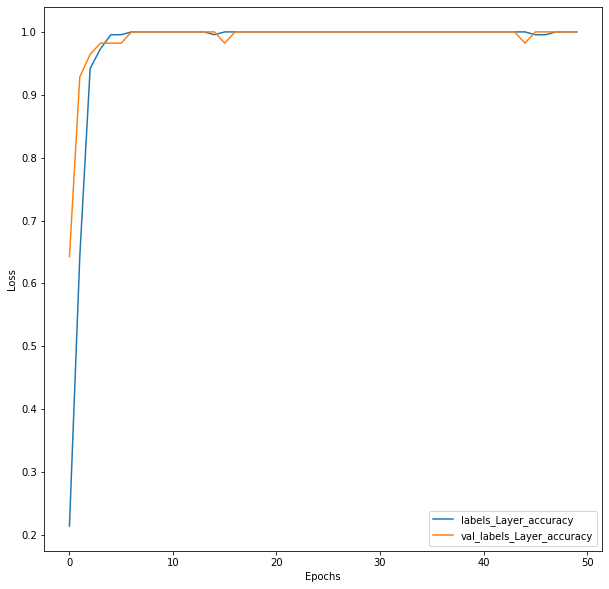

In [27]:
# Train and Validation accuracy graph for VGG16
plt.figure(figsize=(10, 10))
plt.plot(vggModelHistory.history['labels_Layer_accuracy'], label='labels_Layer_accuracy')
plt.plot(vggModelHistory.history['val_labels_Layer_accuracy'], label='val_labels_Layer_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

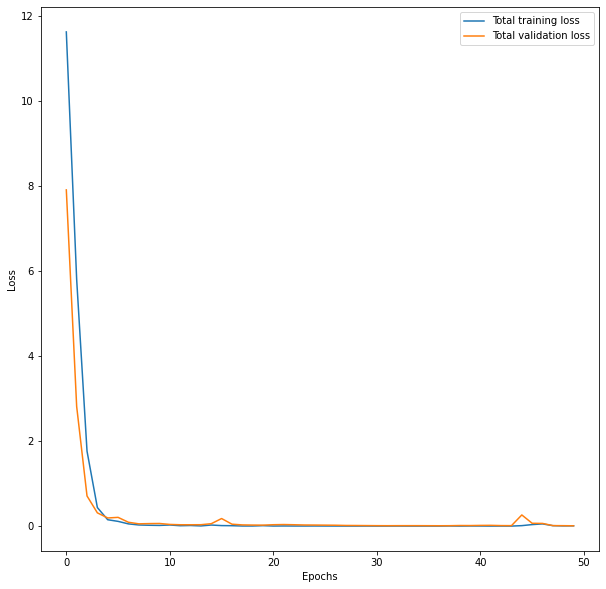

In [28]:
# Train and Validation loss graph for VGG16
plt.figure(figsize=(10, 10))
plt.plot(vggModelHistory.history['loss'], label='Total training loss')
plt.plot(vggModelHistory.history['val_loss'], label='Total validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 245ms/step


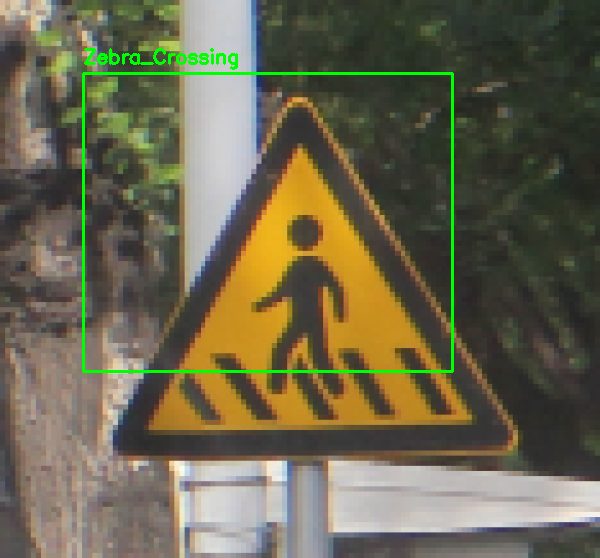

1/1 [==============================] - 0s 25ms/step


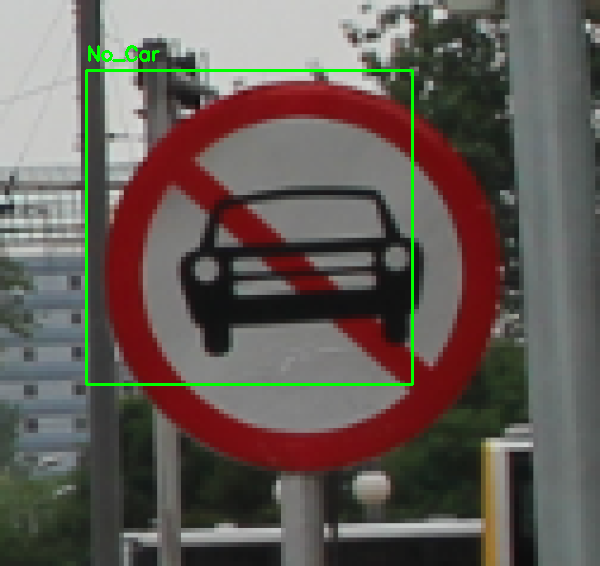

1/1 [==============================] - 0s 30ms/step


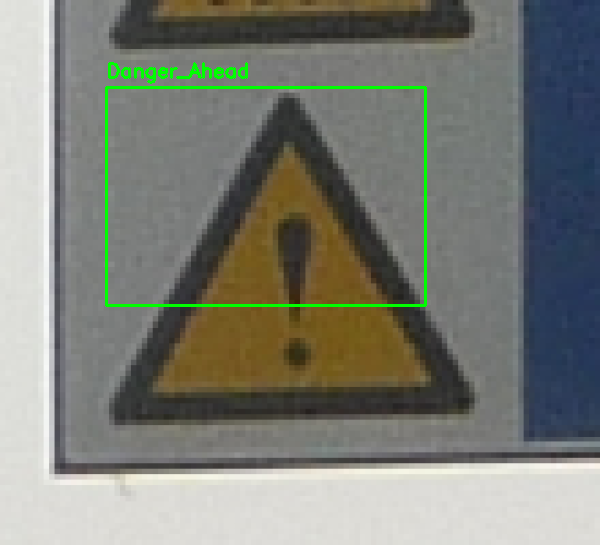

1/1 [==============================] - 0s 29ms/step


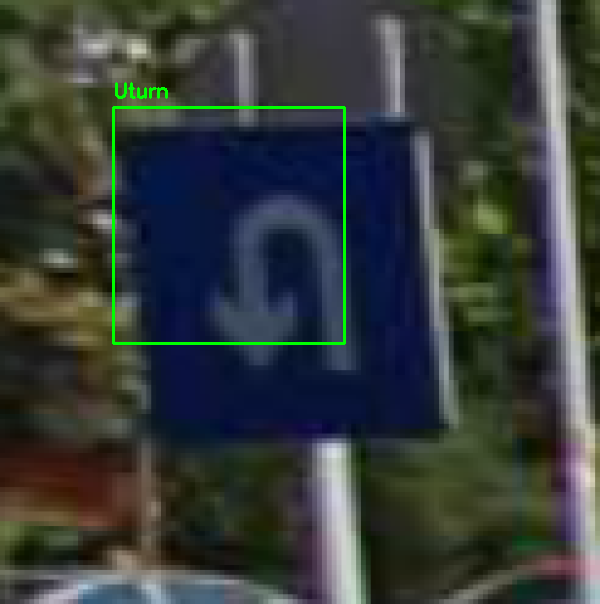

1/1 [==============================] - 0s 23ms/step


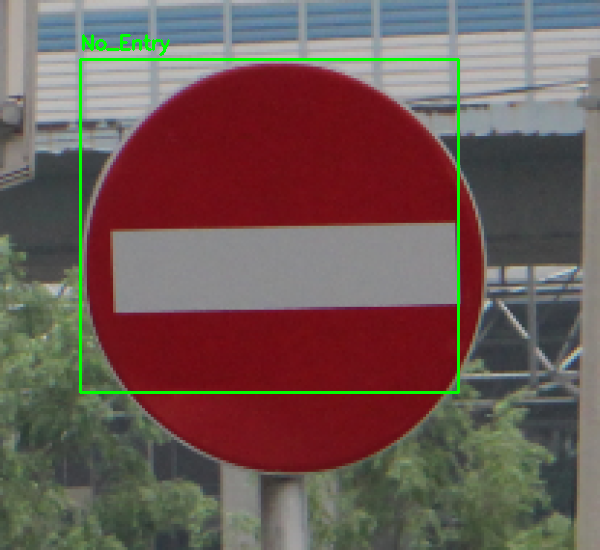

1/1 [==============================] - 0s 22ms/step


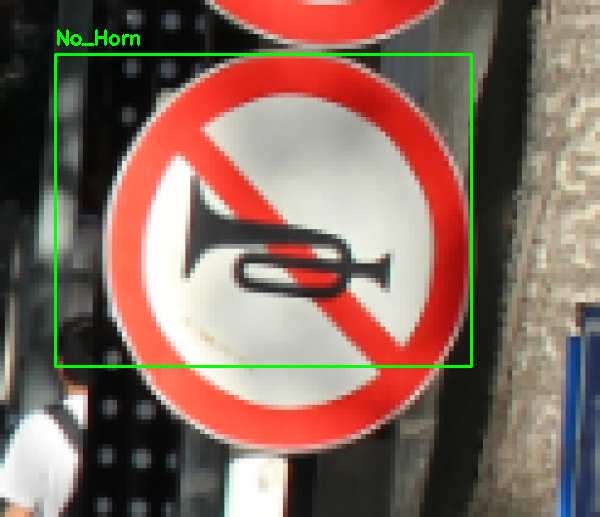

1/1 [==============================] - 0s 24ms/step


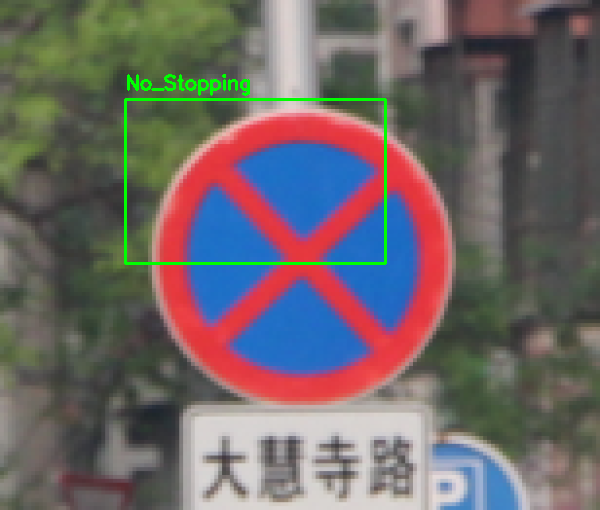

1/1 [==============================] - 0s 23ms/step


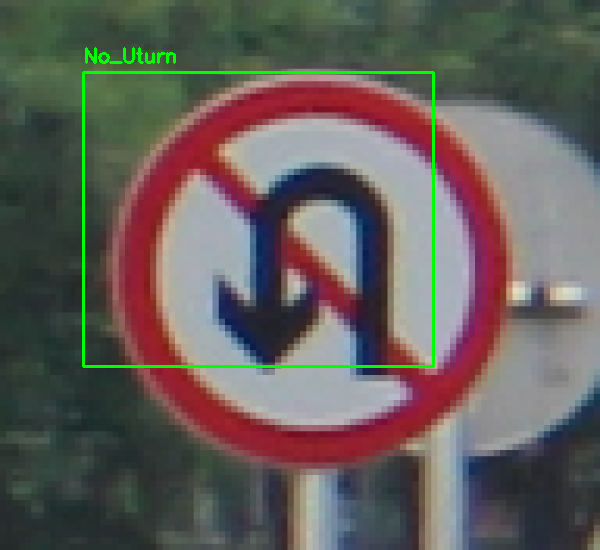

1/1 [==============================] - 0s 29ms/step


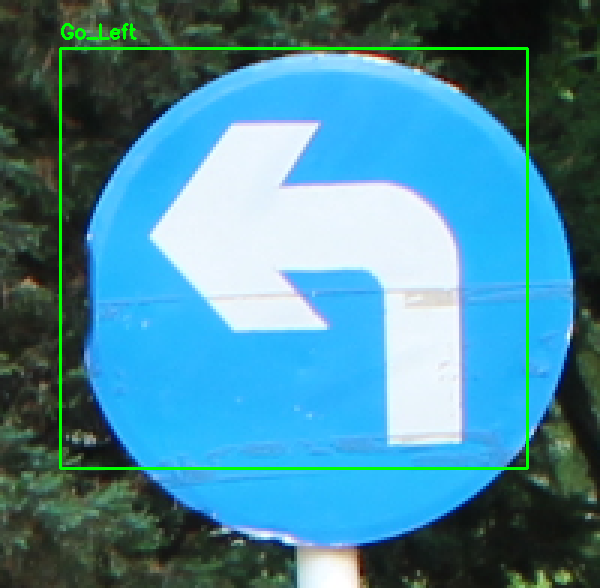

1/1 [==============================] - 0s 33ms/step


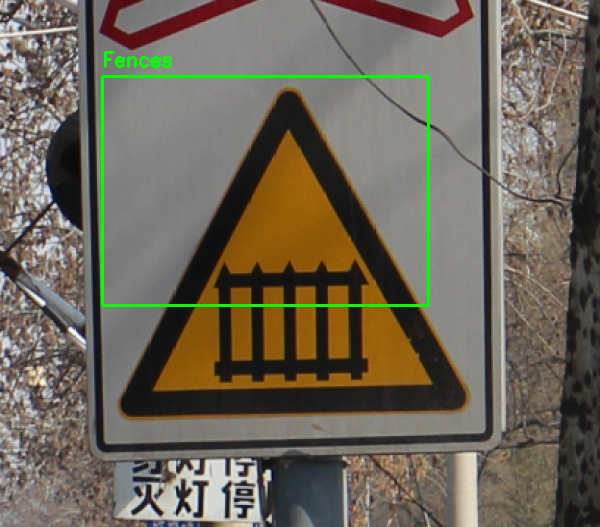

In [29]:
# VGG16 model testing

testImagesPath = currentPath + '/test'
allPaths = os.listdir(testImagesPath)
for path in allPaths:
  imagePath=os.path.join(testImagesPath, path)
  image = load_img(imagePath, target_size=(224, 224))
  image = np.expand_dims((img_to_array(image) / 255.0), axis=0)

  # Prediction
  (labelPreds,boxPreds ) = vggModel.predict(image)

  # Processing
  (xPoint, yPoint, width, height) = boxPreds[0]
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]
  xPoint = int(xPoint * w)
  yPoint = int(yPoint * h)
  width = int(width * w)
  height = int(height * h)
  label = label_to_class_names[np.argmax(labelPreds)]
  y = yPoint - 10 if yPoint - 10 > 10 else yPoint + 10
  cv2.putText(image, label, (xPoint, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
  cv2.rectangle(image, (xPoint, yPoint), (width, height), (0, 255, 0), 2)

  # Showing Image
  cv2_imshow(image)

# Evaluation Between ResNet50 and VGG16 models

After comparing the values of both models, I can see that val_loss of VGG16 is less than that that of ResNet50. Similarly, VGG16 validation accuracies are better than Resnet50. Hence, in this case VGG16 is performing better than ResNet50. 

